In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

In [43]:
sns.set_theme()

In [12]:
comments = pd.read_csv("./data/comments.csv")
posts = pd.read_csv("./data/posts_df.csv")

target = 'Sentiment'
text = 'Body'

In [7]:
comments.shape, posts.shape

((8108, 11), (100, 8))

### Анализ таргета

In [9]:
comments[target].value_counts(normalize=True).round(2) * 100

Sentiment
NEGATIVE    66.0
POSITIVE    34.0
Name: proportion, dtype: float64

### Анализ текстов

In [17]:
# используемые символы -> эмодзи бы расшифровать
''.join(sorted(set(''.join(comments[text]))))

'\n !"#$%&\'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\\]^_abcdefghijklmnopqrstuvwxyz{|}~\xa0¡¢£«¯°»àèéíñʖΑಥ\u200d–—‘’“”„…\u2060€≠⊙☕☝♀♂✊❤ツ️🌮🍔🍞🎉🏆🏻🏼🏾👌👍👏💀💜💩💯💰💷🔔🔥😀😁😂😃😄😅😆😉😊😋😍😎😑😒😔😝😨😪😬😭😮😱😲😳😹🙂🙃🙄🙌🙏🚩🤌🤓🤔🤕🤢🤣🤤🤨🤮🤯🤷🥰🥳🥹🧀🧠🩹🫡🫵'

In [20]:
comments['text_length'] = comments[text].apply(len)
comments['word_count'] = comments[text].apply(lambda x: len(x.split()))

print("Статистика длин текстов:")
display(comments[['text_length', 'word_count']].describe().T)

Статистика длин текстов:


,count,mean,std,min,25%,50%,75%,max
text_length,8108.0,210.903429,247.389035,1.0,62.0,132.0,269.0,3275.0
word_count,8108.0,38.256660,44.461945,1.0,11.0,24.0,49.0,603.0


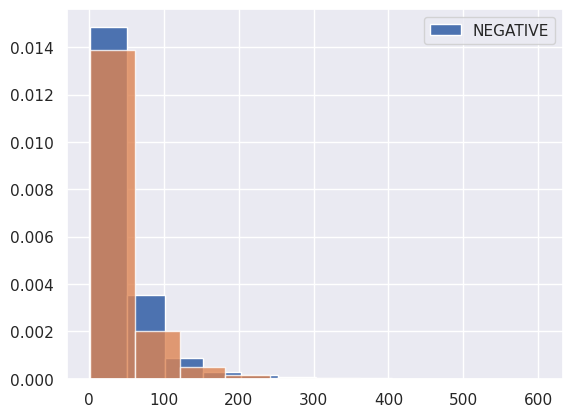

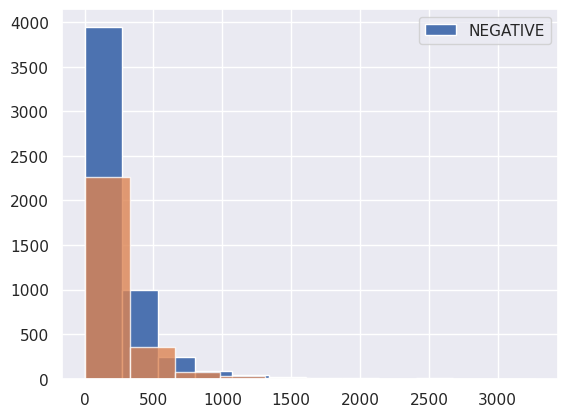

''

In [57]:
# Отнормировать внутри класса
mask = comments[target] == comments[target].iloc[0]
plt.hist(comments[mask]['word_count'], density=True, label=comments[target].iloc[0],)
plt.hist((comments[~mask]['word_count']), alpha=0.8, density=True)
plt.legend()
plt.show()

plt.hist((comments[mask]['text_length']), label=comments[target].iloc[0],)
plt.hist((comments[~mask]['text_length']), alpha=0.8)
plt.legend()
plt.show()
""

In [58]:
comments.isna().sum()

Post_ID               0
Post_Title            0
Comment_ID            0
Parent_ID          4231
Body                  0
Author                0
Score                 0
Level                 0
Sentiment             0
Confidence            0
Sentiment_Score       0
text_length           0
word_count            0
dtype: int64

In [60]:
comments.nunique() / comments.shape[0]

Post_ID            0.012333
Post_Title         0.012333
Comment_ID         1.000000
Parent_ID          0.324124
Body               0.980266
Author             0.572398
Score              0.023557
Level              0.000247
Sentiment          0.000247
Confidence         0.942526
Sentiment_Score    0.000370
text_length        0.114208
word_count         0.033424
dtype: float64

In [67]:
# Удалим дубликаты и напоминалки.
comments.groupby(text)[['Post_ID']].count().query("Post_ID > 1").sort_values(by="Post_ID", ascending=False).head()

,Post_ID
Body,
"Please remember what subreddit you are in, this is unpopular opinion. We want civil and unpopular takes and discussion. Any uncivil and ToS violating comments will be removed and subject to a ban. Have a nice day!\n\n\n*I am a bot, and this action was performed automatically. Please [contact the moderators of this subreddit](/message/compose/?to=/r/unpopularopinion) if you have any questions or concerns.*",94
[deleted],21
[removed],6
🧀,5
I agree that videogames is some of the best value for money entertainment but that's not justification for the price hike on these games. 60 bucks was a lot for a game when I was a kid and id have been crazy to ask my parents for a new game I'm 28 now and still struggle justifying paying 80 dollars for a game and will often just wait for a sale. I will be buying GTA 6 day 1 though 😭😭😭,5


In [86]:
def preprocess_text(text):
    import re
    """Базовая предобработка для анализа слов"""
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # Удалить URL
    text = re.sub(r'@\w+|#\w+', '', text)  # Удалить @mentions и #hashtags
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)  # Оставить только буквы
    words = text.split()
    words = [w for w in words if len(w) > 2]  # Удалить короткие слова
    if type(words) == int:
        print(text)
    return words

In [87]:
comments['prep_text'] = comments[text].apply(lambda x: preprocess_text(x))

In [94]:
from collections import Counter

In [126]:
ans_neg = []
for i in comments[comments[target] == "NEGATIVE"]['prep_text'].values.tolist():
    ans_neg += i

# Проведем очистку по стоп-словам. 
count_neg = Counter(ans_neg)
count_neg.most_common(10)

[('the', 6994),
 ('and', 5208),
 ('you', 4491),
 ('that', 3177),
 ('for', 2235),
 ('they', 1856),
 ('are', 1839),
 ('have', 1699),
 ('not', 1698),
 ('but', 1633)]

In [127]:
ans_pos = []
for i in comments[comments[target] != "NEGATIVE"]['prep_text'].values.tolist():
    ans_pos += i
count_pos = Counter(ans_pos)
count_pos.most_common(10)

[('the', 3126),
 ('and', 2602),
 ('you', 1967),
 ('that', 1489),
 ('for', 957),
 ('but', 955),
 ('with', 880),
 ('are', 861),
 ('have', 730),
 ('they', 668)]

### Анализ утечек

In [128]:
# Подумать над коэффициентом K.
K = 5
set_pos = set([i for i in count_pos if count_pos[i] > K])
set_neg = set([i for i in count_neg if count_neg[i] > K])

In [129]:
# Разница в словарях в разрезе классов. Убрать бы редко встречающиеся слова
display((len(set(ans_pos) - set(ans_neg)), len(set(ans_neg) - set(ans_pos))))
display((len(set_pos - set_neg), len(set_neg - set_pos)))


(2298, 6120)

(92, 1338)

In [130]:
len(set(ans_pos)), len(set(ans_neg)), len([i for i in count_pos if count_pos[i] < K]), len([i for i in count_neg if count_neg[i] < K])

(8146, 11968, 6277, 8709)

### other

In [3]:
comments.head().T

,0,1,2,3,4
Post_ID,1l3e2dt,1l3e2dt,1l3e2dt,1l3e2dt,1l3e2dt
Post_Title,Video games are addictive by design and partic...,Video games are addictive by design and partic...,Video games are addictive by design and partic...,Video games are addictive by design and partic...,Video games are addictive by design and partic...
Comment_ID,mw03xn7,mw046xq,mw04of4,mw04qz8,mw04rp1
Parent_ID,NaN,NaN,NaN,NaN,NaN
Body,"Please remember what subreddit you are in, thi...",> video games are predatory and designed to su...,"you're painting with an extremely broad brush,...",lol...don't enjoy something. Get back to work!,Video games being more addictive than other so...
Author,AutoModerator,NoahtheRed,Potential-Load9313,NetJnkie,GrilledStuffedDragon
Score,1,1,1,1,1
Level,0,0,0,0,0
Sentiment,NEGATIVE,NEGATIVE,NEGATIVE,NEGATIVE,NEGATIVE
Confidence,0.995359,0.975293,0.791755,0.998284,0.997701


In [10]:
import matplotlib.pyplot as plt

(array([  67.,   86.,   73.,  112.,  101.,  119.,  150.,  224.,  424.,
        6752.]),
 array([0.5013032 , 0.55116162, 0.60102005, 0.65087848, 0.7007369 ,
        0.75059533, 0.80045376, 0.85031219, 0.90017061, 0.95002904,
        0.99988747]),
 <BarContainer object of 10 artists>)

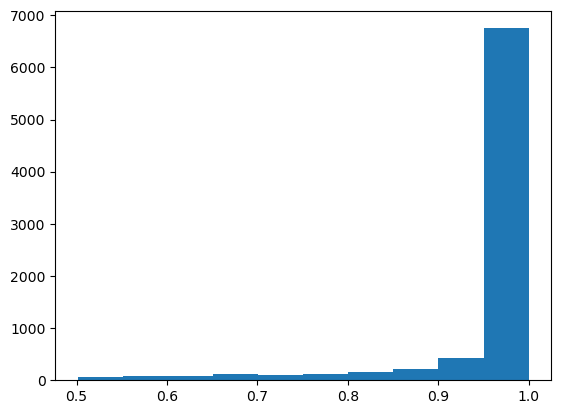

In [12]:
plt.hist(comments['Confidence'])

In [13]:
comments.isna().sum()

Post_ID               0
Post_Title            0
Comment_ID            0
Parent_ID          4231
Body                  0
Author                0
Score                 0
Level                 0
Sentiment             0
Confidence            0
Sentiment_Score       0
dtype: int64

In [14]:
posts = pd.read_csv("./data/posts_df.csv")

In [18]:
pd.merge(comments, posts, how='left', on='Post_ID').head().T

,0,1,2,3,4
Post_ID,1l3e2dt,1l3e2dt,1l3e2dt,1l3e2dt,1l3e2dt
Post_Title,Video games are addictive by design and partic...,Video games are addictive by design and partic...,Video games are addictive by design and partic...,Video games are addictive by design and partic...,Video games are addictive by design and partic...
Comment_ID,mw03xn7,mw046xq,mw04of4,mw04qz8,mw04rp1
Parent_ID,NaN,NaN,NaN,NaN,NaN
Body,"Please remember what subreddit you are in, thi...",> video games are predatory and designed to su...,"you're painting with an extremely broad brush,...",lol...don't enjoy something. Get back to work!,Video games being more addictive than other so...
Author_x,AutoModerator,NoahtheRed,Potential-Load9313,NetJnkie,GrilledStuffedDragon
Score_x,1,1,1,1,1
Level,0,0,0,0,0
Sentiment,NEGATIVE,NEGATIVE,NEGATIVE,NEGATIVE,NEGATIVE
Confidence,0.995359,0.975293,0.791755,0.998284,0.997701


In [24]:
pd.set_option("display.max_colwidth", None)

comments[["Body", "Sentiment"]].head()

,Body,Sentiment
0,"Please remember what subreddit you are in, this is unpopular opinion. We want civil and unpopular takes and discussion. Any uncivil and ToS violating comments will be removed and subject to a ban. Have a nice day!\n\n\n*I am a bot, and this action was performed automatically. Please [contact the moderators of this subreddit](/message/compose/?to=/r/unpopularopinion) if you have any questions or concerns.*",NEGATIVE
1,> video games are predatory and designed to suck you in and keep you locked down.\n\nExplain. Not agreeing or disagreeing. Just curious as to how you arrived at this conclusion.,NEGATIVE
2,"you're painting with an extremely broad brush, and if you don't think scrolling is more addictive than ""video games"" then I don't think you have the mental capacity to form any further arguments.",NEGATIVE
3,lol...don't enjoy something. Get back to work!,NEGATIVE
4,Video games being more addictive than other sorts of media is *highly* subjective.\n\nYou can't just make that claim and then walk away without explaining how and why you feel your assertion is factual reality.,NEGATIVE
